In [ ]:
# This notebook contains code for running the greedy approach against
# the linear approximation and random baselines (Section 4.1)

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import gzip

from copy import deepcopy
from matplotlib import pyplot as plt
from scipy import stats
import matplotlib.ticker as mtick
import Levenshtein as lev

import torch
from torch.nn import parallel

<h3>Greedy Algorithm</h3>

In [2]:
# Utility functions

# f(x) = min(n, x)
def getThresholdUtility(n):
    return torch.tensor(np.arange(0,n+1,1),dtype = torch.float32)

# Random concave function
def getRandomConcaveUtility(n, rng):
    d = rng.normal(0,2,n+2)
    d = -np.exp(d) #Lognormal
    d = np.cumsum(d)
    d = (d - d[-1])[:-1]
    d = np.cumsum(d)
    d = d - d[0]
    d = d/d[-1]
    d = torch.tensor(d, dtype = torch.float32)
    return d

def getMarginalImprovement(utility):
    return torch.cat( (utility[1:] - utility[:-1], torch.zeros(1)) )

def dedupe_designs(seqs):
    seen = set()
    seqs2 = []
    for seq in seqs:
        if seq not in seen: seqs2.append(seq)
        seen.add(seq)
    return seqs2

In [3]:
#candidates: [candidate, 1 - pMHC hit probability]
#columnIndex: [diplotype, allele in diplotype]
#columnWeights: [diplotype]
#distributions: [dummy, diplotype, distribution]
#marginalImprovement: [improvement (shifting from i to i+1, so last entry should be 0)]

def evaluateCandidates(candidates, columnIndex, columnWeights, distributions, marginalImprovement):
    probabilityOfHit = 1 - candidates
    shiftedMass = distributions * probabilityOfHit
    improvement = torch.sum( shiftedMass * marginalImprovement, dim = 2)
    weightedImprovement = torch.sum( improvement * columnWeights, dim = 1)
    return weightedImprovement

def updateDistribution(newRow, columnIndex, distributions):
    probabilityOfMiss = torch.prod(newRow[columnIndex], dim = 1).reshape(1, -1, 1)
    shiftedMass = distributions * (1-probabilityOfMiss)
    
    convolution = distributions * probabilityOfMiss
    convolution[:,:,1:] += shiftedMass[:,:,:-1]
    convolution[:,:,-1] += shiftedMass[:,:,-1]
    return convolution

def evaluateDesign(candidates, seqs, columnIndex, columnWeights, design, utility):
    design = dedupe_designs(design)
    distributions = torch.zeros( (1, len(columnIndex), len(utility)) )
    distributions[:, :, 0] = 1
    
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    for seq in design:
        if seq not in seqToIndex: continue
        row = seqToIndex[seq]
        distributions = updateDistribution(candidates[row], columnIndex, distributions)
        
    scores = torch.sum( distributions * utility.view(1,1,-1), dim = 2 ).reshape(-1)
    return torch.sum(scores * columnWeights).item()

def evaluateDesignTrajectory(candidates, seqs, columnIndex, columnWeights, design, utility):
    design = dedupe_designs(design)
    distributions = torch.zeros( (1, len(columnIndex), len(utility)) )
    distributions[:, :, 0] = 1
    
    seqToIndex = {}
    for i, seq in enumerate(seqs):
        seqToIndex[seq] = i
        
    scores = []
    for seq in design:
        row = seqToIndex[seq]
        distributions = updateDistribution(candidates[row], columnIndex, distributions)
        currentScores = torch.sum( distributions * utility.view(1,1,-1), dim = 2 ).reshape(-1)
        scores.append(torch.sum(currentScores * columnWeights).item())
        
    return scores

In [5]:
class evaluateCandidatesModule(torch.nn.Module):
    def __init__(self, columnIndex, columnWeights, marginalImprovement, device):
        super(evaluateCandidatesModule, self).__init__()
        self.device = device
        self.columnIndex = columnIndex
        self.columnWeights = columnWeights.cuda(self.device)
        self.marginalImprovement = marginalImprovement.cuda(self.device)
        
    def updateDistributions(self, distributions):
        self.distributions = distributions.cuda(self.device)
        
    def forward(self, candidates):
        probabilityOfHit = 1 - torch.prod(candidates[:, self.columnIndex], dim = 2).unsqueeze(2)
        shiftedMass = self.distributions * probabilityOfHit
        improvement = torch.sum( shiftedMass * self.marginalImprovement, dim = 2)
        weightedImprovement = torch.sum( improvement * self.columnWeights, dim = 1)
        return weightedImprovement.cpu()

def greedySelectionMulticore(candidates,
                             seqs,
                             columnIndex,
                             columnWeights,
                             designSize,
                             marginalImprovement,
                             threshold,
                             batchSize,
                             devices):
    
    # Set up modules on different devices
    modules = [evaluateCandidatesModule(columnIndex, columnWeights, marginalImprovement, device)
               for device in devices]
    
    # Distribute the computation between devices
    numRows = candidates.shape[0]
    numVertical = (numRows//(len(devices) * batchSize))
    sliceSize = (numRows//(len(devices) * numVertical)) + 1
    slices = []
    z = 0
    for _ in range(numVertical):
        singleSlice = []
        if z*sliceSize >= numRows: break
        for device in devices:
            if z == numVertical * len(devices) - 1:
                singleSlice.append( candidates[z*sliceSize:].cuda(device) )
            else:
                singleSlice.append( candidates[z*sliceSize:(z+1)*sliceSize].cuda(device) )
            z += 1
        slices.append(singleSlice)
    
    # Initialize selected set and score
    selectedScores = []
    selectedSet = []
    score = 0
    selectable = np.ones(numRows)
    
    # Initialize coverage distributions
    distributions = torch.zeros( (1, len(columnIndex), len(marginalImprovement)) )
    distributions[:, :, 0] = 1
    
    numberOfSlices = len(slices)
    for _ in range(designSize):
        # Update distributions in modules
        for module in modules:
            module.updateDistributions(distributions)

        # Compute marginal utilities
        allImprovements = []
        # We need to batch the following vector operations due to space limitations
        for sliceIndex, singleSlice in enumerate(slices):
            improvements = parallel.parallel_apply(modules, singleSlice)
            allImprovements.append(torch.cat(improvements))
        allImprovements = torch.cat(allImprovements).numpy()

        # Argmax
        selection = np.argmax(allImprovements * selectable)
        
        # Add sequence to selection
        selectedSeq = seqs[selection]
        selectedSet.append(selectedSeq)

        # Remove chosen sequence from consideration
        selectable[selection] = 0

        # Update score
        delta = allImprovements[selection]
        score += delta
        selectedScores.append(score)

        # Update distributions for next round
        distributions = updateDistribution(candidates[selection], columnIndex, distributions)
    
    torch.cuda.empty_cache()
    return selectedSet

In [6]:
# Baseline methods

# Linear approximation
def greedySelectionLinear(candidates,
                             seqs,
                             columnIndex,
                             columnWeights,
                             designSize,
                             utility):
    probabilityOfHit = 1 - candidates
    expectedMarginalGain = torch.sum( probabilityOfHit * columnWeights.view(1,-1), dim = 1 )
    design = seqs[ np.argsort( -expectedMarginalGain.numpy() )[:designSize] ]
    scores = evaluateDesignTrajectory(candidates, seqs, columnIndex, columnWeights, design, utility)
    return scores
    
# Random selection
def greedySelectionRandom(candidates,
                             seqs,
                             columnIndex,
                             columnWeights,
                             designSize,
                             utility,
                             rng):
    design = seqs[rng.permutation( len(seqs) )[:designSize]]
    scores = evaluateDesignTrajectory(candidates, seqs, columnIndex, columnWeights, design, utility)
    return scores

<h3>Analysis</h3>

In [7]:
def makeDataset(nPeptides, nGenotypes, ev, rng):
    data = rng.uniform(0,1,(nPeptides, nGenotypes)) ** ((1-ev)/ev)
    seqs = np.arange(0, nPeptides, 1, dtype = np.int32)
    columnIndex = np.arange(0, nGenotypes, 1, dtype = np.int32).reshape(-1, 1)
    weights = rng.exponential(scale = 1,  size = nGenotypes)
    weights = weights/np.sum(weights)
    
    data = torch.tensor(1-data, dtype = torch.float)
    weights = torch.tensor(weights, dtype = torch.float)
    return data, seqs, columnIndex, weights

def runExperiment(nPeptides, nGenotypes, ev, utility, rng_data, rng_selection):
    dataset = makeDataset(nPeptides, nGenotypes, ev, rng_data)
    greedy = greedySelectionMulticore(*dataset,
                   64,
                   getMarginalImprovement( utility ),
                   0,
                   50,
                   list(range(torch.cuda.device_count())))
    greedyScores = evaluateDesignTrajectory(*dataset, greedy, utility)
    linear = greedySelectionLinear(*dataset, 64, utility)
    random = greedySelectionRandom(*dataset, 64, utility, rng_selection)
    return np.array( [greedyScores, linear, random] )

# Set seeds
rng_func = np.random.RandomState(1137296379)
rng_data = np.random.RandomState(2124315856)
rng_selection = np.random.RandomState(1639313996)

# Results of the experiment will be stored here
results_randutil = []

# nsamples is the number of samples to collect. Change to something smaller if
# you wish to run a quick check
nsamples = 2000

for _ in tqdm(range(nsamples), position = 0, leave = True):
    distribution = 0.005 * ( 100 ** (rng_func.uniform(0,1)) )
    nPeptides = rng_func.randint(512, 2049)
    nGenotypes = rng_func.randint(512, 2049)
    util = getRandomConcaveUtility(10, rng_func)
    
    x = runExperiment(nPeptides,
                      nGenotypes,
                      distribution,
                      util,
                      rng_data, rng_selection)
    #These are genotypes, not haplotypes. Keeping the name to avoid bugs
    results_randutil.append( (x,util.numpy(),nPeptides,nGenotypes,distribution) )

100%|██████████| 10/10 [00:42<00:00,  2.43s/it]


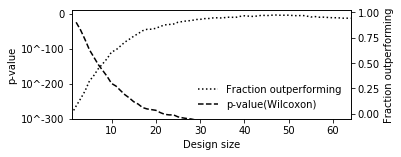

In [12]:
# This block of code was used for generating Figure 2. For additional analysis, results_randutil
# contains all the necessary data from the experiment.

# results_randutil contains the output of the experiment as a list of tuples, each with the following entries:
# 1. a matrix with three rows, where each row contains a design trajectory.
#    The ith entry in the row (zero indexed) contains the score of the design of size i+1.
#    The matrix contains three rows: row 0 gives the trajectory of the greedy solution,
#    row 1 gives the trajectory of the linear approximation solution, and row 2
#    gives the trajectory of the random solution.
# 2. The utility function as an array, where entry i contains it output on i.
# 3. The number of peptides.
# 4. The number of genotypes.
# 5. The parameter used to generate the distribution.

def getOutperformanceTrajectory(results):
    tmain = [] # Greedy method
    tsub = [] # Maximum over the baseline methods
    for trajectory in results:
        trajectory = trajectory[0]
        tmain.append(trajectory[0])
        tsub.append(np.maximum(trajectory[1], trajectory[2]))
    return np.array(tmain).T, np.array(tsub).T

performanceTrajectory = getOutperformanceTrajectory(results_randutil)

def plotTrajectoryPV(t1, t2, ax):
    fc = lambda x : -400 if x == 0 else np.log(x)/np.log(10)
    ps = []
    for a,b in zip(t1[1:], t2[1:]): #Linear approximation and greedy are both optimal for designs of size one
        p = stats.wilcoxon(a,b,alternative="greater")
        ps.append( fc(p[1] * len(t1)) ) # Multiple hypothesis testing
    
    xs = np.arange(2, len(t1)+1, 1) #Linear approximation and greedy are both optimal for designs of size one
    return ax.plot(xs, ps, linestyle = "--", color = "black")
    
def plotTrajectoryRawFraction(t1, t2, ax):
    fraction = np.mean(t1 > t2, axis = 1)
    xs = np.arange(1, len(fraction)+1, 1)
    return ax.plot(xs, fraction, linestyle = ":", color = "black")
    
_, ax = plt.subplots(1,1,figsize = (5,2))
ax2 = ax.twinx()
l1, = plotTrajectoryRawFraction(*performanceTrajectory, ax2)
l2, = plotTrajectoryPV(*performanceTrajectory, ax)
ax.set_ylim(-300, 10)
ax.set_ylabel("p-value")
ax2.set_ylabel("Fraction outperforming")
ax.set_yticks([-300, -200, -100, 0])
ax.set_yticklabels(["10^-{}".format(z) for z in (300, 200, 100)] + ["0"])
ax.set_xlim(1,64)
ax.set_xlabel("Design size")
plt.legend([l1, l2], ["Fraction outperforming", "p-value(Wilcoxon)"], framealpha = 0)
plt.show()